## RATECE-PLANICA ski station (Slovenia) under CMIP-6 SSP585 condition

- **Description**: SSP-based RCP scenario with high radiative forcing by the end of century. Following approximately RCP8.5 global forcing pathway with SSP5 socioeconomic conditions. Concentration-driven.
- **Rationale**: the scenario represents the high end of plausible future pathways. SSP5 is the only SSP with emissions high enough to produce the 8.5 W/m2 level of forcing in 2100.
- Full description on [ES-DOC](https://view.es-doc.org/?renderMethod=name&project=cmip6&type=cim.2.designing.NumericalExperiment&client=esdoc-url-rewrite&name=ssp585)

### Is it worth investing in artificial snowmaking equipment at RATECE-PLANICA?

In [42]:
from ipyleaflet import Map, Marker, basemaps

center = (46.5, 13.70)

m = Map(
    basemap=basemaps.OpenTopoMap, 
    center=center,
    zoom=7
)
marker = Marker(location=center,  draggable=False)
m.add_layer(marker);
m

Map(center=[46.5, 13.7], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out…

In [1]:
import xarray as xr
import pandas as pd
import cftime
import intake
from dask.distributed import Client
from dask.distributed import wait, progress
xr.set_options(display_style='html')
%matplotlib inline

/opt/conda/lib/python3.7/site-packages/matplotlib/font_manager.py:281: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


# Step-1: Observation mean and standard deviation at RATECE-PLANICA station

## Time series - daily RATECE-PLANICA average temperature

- coordinates: 46.50N, 13.70E, 864.0m
- GHCN-D station code: SIE00115206 RATECE-PLANICA Slovenia

In [2]:
filename = 'http://berkeleyearth.lbl.gov/auto/Stations/TAVG/Text/22498-TAVG-Data.txt'
data = pd.read_csv(filename, sep='\s+', header=None, comment='%')

### Compute mean and standard deviation from 1961-2005

In [3]:
mean_st_1961_2005 = data[(data[0] >= 1961 ) & (data[0] <= 2005)][6].mean()
std_st_1961_2005 = data[(data[0] >= 1961 ) & (data[0] <= 2005)][6].std()
print(mean_st_1961_2005 + 273.15, std_st_1961_2005)

279.7723153988868 7.3015251282000255


### Store results in csv file

In [4]:
# list of values 
lst = [mean_st_1961_2005 + 273.15, std_st_1961_2005] 
  
# Calling DataFrame constructor on list 
# with indices and columns specified 
df_st = pd.DataFrame(lst, index =['mean', 'stddev'], 
                                              columns =['RATECE-PLANICA-T2M-1961-2005']) 
df_st.to_csv('RATECE-PLANICA-1961-2005_t2m.csv') 

In [5]:
df_st

,RATECE-PLANICA-T2M-1961-2005
mean,279.772315
stddev,7.301525


# Step-2: CMIP-6 mean and standard deviation at RATECE-PLANICA

- We will be using one model CNRM-CM6-1-HR

### Check catalog and get model data

In [6]:
col_url = "https://raw.githubusercontent.com/NCAR/intake-esm-datastore/master/catalogs/pangeo-cmip6.json"

In [7]:
col = intake.open_esm_datastore(col_url)

In [8]:
cat = col.search(experiment_id=['historical', 'ssp585'], table_id='day',
          variable_id=['tas', 'tasmin', 'tasmax'], source_id='CNRM-CM6-1-HR', institution_id='CNRM-CERFACS')

In [9]:
cat.df

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year
0,CMIP,CNRM-CERFACS,CNRM-CM6-1-HR,historical,r1i1p1f2,day,tas,gr,gs://cmip6/CMIP/CNRM-CERFACS/CNRM-CM6-1-HR/his...,NaN
1,CMIP,CNRM-CERFACS,CNRM-CM6-1-HR,historical,r1i1p1f2,day,tasmax,gr,gs://cmip6/CMIP/CNRM-CERFACS/CNRM-CM6-1-HR/his...,NaN
2,CMIP,CNRM-CERFACS,CNRM-CM6-1-HR,historical,r1i1p1f2,day,tasmin,gr,gs://cmip6/CMIP/CNRM-CERFACS/CNRM-CM6-1-HR/his...,NaN
3,ScenarioMIP,CNRM-CERFACS,CNRM-CM6-1-HR,ssp585,r1i1p1f2,day,tas,gr,gs://cmip6/ScenarioMIP/CNRM-CERFACS/CNRM-CM6-1...,NaN
4,ScenarioMIP,CNRM-CERFACS,CNRM-CM6-1-HR,ssp585,r1i1p1f2,day,tasmax,gr,gs://cmip6/ScenarioMIP/CNRM-CERFACS/CNRM-CM6-1...,NaN
5,ScenarioMIP,CNRM-CERFACS,CNRM-CM6-1-HR,ssp585,r1i1p1f2,day,tasmin,gr,gs://cmip6/ScenarioMIP/CNRM-CERFACS/CNRM-CM6-1...,NaN


In [10]:
dset_dict = cat.to_dataset_dict(zarr_kwargs={'consolidated': True})
list(dset_dict.keys())

Progress: |███████████████████████████████████████████████████████████████████████████████| 100.0% 

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'
             
--> There are 2 group(s)


['ScenarioMIP.CNRM-CERFACS.CNRM-CM6-1-HR.ssp585.day.gr',
 'CMIP.CNRM-CERFACS.CNRM-CM6-1-HR.historical.day.gr']

### Create dask cluster

In [11]:
# Select 10 'workers' under 'manual scaling' menu below and click 'Scale'
# Click on the 'Dashboard link' to monitor calculation progress
from dask.distributed import Client
client = Client(n_workers=10, threads_per_worker=2, memory_limit='60GB')

### Model mean and standard deviation 1961-2005

In [12]:
ds_hist = dset_dict['CMIP.CNRM-CERFACS.CNRM-CM6-1-HR.historical.day.gr']
ds_hist

<xarray.Dataset>
Dimensions:      (axis_nbounds: 2, lat: 360, lon: 720, member_id: 1, time: 60265)
Coordinates:
    time_bounds  (time, axis_nbounds) datetime64[ns] dask.array<chunksize=(30133, 1), meta=np.ndarray>
    height       float64 2.0
  * time         (time) datetime64[ns] 1850-01-01T12:00:00 ... 2014-12-31T12:00:00
  * lat          (lat) float64 -89.62 -89.12 -88.62 -88.13 ... 88.62 89.12 89.62
  * lon          (lon) float64 0.0 0.5 1.0 1.5 2.0 ... 358.0 358.5 359.0 359.5
  * member_id    (member_id) <U8 'r1i1p1f2'
Dimensions without coordinates: axis_nbounds
Data variables:
    tas          (member_id, time, lat, lon) float32 dask.array<chunksize=(1, 94, 360, 720), meta=np.ndarray>
    tasmax       (member_id, time, lat, lon) float32 dask.array<chunksize=(1, 94, 360, 720), meta=np.ndarray>
    tasmin       (member_id, time, lat, lon) float32 dask.array<chunksize=(1, 93, 360, 720), meta=np.ndarray>
Attributes:
    grid:                   data regridded to a 359 gaussian grid (360x720 la...
    variant_label:          r1i1p1f2
    grid_label:             gr
    references:             http://www.umr-cnrm.fr/cmip6/references
    parent_activity_id:     C M I P
    external_variables:     areacella
    xios_commit:            1442-shuffle
    CMIP6_CV_version:       cv=6.2.3.0-7-g2019642
    parent_time_units:      days since 1850-01-01 00:00:00
    product:                model-output
    realm:                  atmos
    institution_id:         CNRM-CERFACS
    branch_time_in_parent:  0.0
    branch_method:          standard
    institution:            CNRM (Centre National de Recherches Meteorologiqu...
    license:                CMIP6 model data produced by CNRM-CERFACS is lice...
    parent_source_id:       CNRM-CM6-1-HR
    intake_esm_varname:     tasmin
    sub_experiment_id:      none
    parent_mip_era:         CMIP6
    status:                 2019-11-16;created;by nhn2@columbia.edu
    mip_era:                CMIP6
    history:                none
    nominal_resolution:     50 km
    branch_time_in_child:   0.0
    parent_experiment_id:   p i C o n t r o l
    creation_date:          2019-05-23T12:33:55Z
    dr2xml_version:         1.16
    source_type:            AOGCM
    EXPID:                  CNRM-CM6-1-HR_historical_r1i1p1f2
    source:                 CNRM-CM6-1-HR (2017):  aerosol: prescribed monthl...
    sub_experiment:         none
    source_id:              CNRM-CM6-1-HR
    dr2xml_md5sum:          45d4369d889ddfb8149d771d8625e9ec
    table_id:               day
    activity_id:            CMIP
    variable_id:            tasmin
    frequency:              day
    realization_index:      1
    parent_variant_label:   r1i1p1f2
    initialization_index:   1
    forcing_index:          2
    contact:                contact.cmip@meteo.fr
    physics_index:          1
    data_specs_version:     01.00.21
    experiment:             all-forcing simulation of the recent past
    nemo_gelato_commit:     84a9e3f161dade7_8250e198106a168
    title:                  CNRM-CM6-1-HR model output prepared for CMIP6 and...
    description:            CMIP6 historical
    Conventions:            CF-1.7 CMIP-6.2
    tracking_id:            hdl:21.14100/8674f71e-9cba-4ef2-b5a5-8a5963e491c7...
    experiment_id:          historical
    further_info_url:       https://furtherinfo.es-doc.org/CMIP6.CNRM-CERFACS...
    arpege_minor_version:   6.3.3

In [13]:
p = ds_hist['tas'].sel(time=slice(pd.datetime(1961, 1, 1), pd.datetime(2005, 12, 31))).sel(lat=46.5,lon=13.7, method="nearest")

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  """Entry point for launching an IPython kernel.


In [14]:
p

,Array,Chunk
Bytes,65.74 kB,376 B
Shape,"(1, 16435)","(1, 94)"
Count,1637 Tasks,176 Chunks
Type,float32,numpy.ndarray


In [15]:
mean_cmip6_1961_2005 = p.mean().values
std_cmip6_1961_2005 = p.std().values
print(mean_cmip6_1961_2005, std_cmip6_1961_2005)

276.1684 8.298349


In [16]:
# list of values 
lst = [mean_cmip6_1961_2005, std_cmip6_1961_2005] 
  
# Calling DataFrame constructor on list 
# with indices and columns specified 
df_cmip6 = pd.DataFrame(lst, index =['mean', 'stddev'], 
                                              columns =['RATECE-PLANICA-T2M-1961-2005']) 
df_cmip6.to_csv('RATECE-PLANICA-1961-2005_t2m_cmip6.csv') 

In [17]:
df_cmip6

,RATECE-PLANICA-T2M-1961-2005
mean,276.168396
stddev,8.298349


# Step-3: CMIP-6 Model data historical 1961 - 2010 
- 'maximum_2m_temperature_in_the_last_24_hours'
- 'minimum_2m_temperature_in_the_last_24_hours'

## Apply bias correction to tasmin for historical 

In [18]:
p = ds_hist['tasmin'].sel(time=slice(pd.datetime(1961, 1, 1), pd.datetime(2010, 12, 31))).sel(lat=46.5,lon=13.7, method="nearest")
t2min_h_bias_corrected = (p - mean_cmip6_1961_2005)/std_cmip6_1961_2005 * std_st_1961_2005 + mean_st_1961_2005
t2min_h_bias_corrected

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  """Entry point for launching an IPython kernel.


,Array,Chunk
Bytes,73.04 kB,372 B
Shape,"(1, 18261)","(1, 93)"
Count,2487 Tasks,198 Chunks
Type,float32,numpy.ndarray


## Apply bias correction to tasmax for historical 

In [19]:
p = ds_hist['tasmax'].sel(time=slice(pd.datetime(1961, 1, 1), pd.datetime(2010, 12, 31))).sel(lat=46.5,lon=13.7, method="nearest")
t2max_h_bias_corrected = (p - mean_cmip6_1961_2005)/std_cmip6_1961_2005 * std_st_1961_2005 + mean_st_1961_2005
t2max_h_bias_corrected

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  """Entry point for launching an IPython kernel.


,Array,Chunk
Bytes,73.04 kB,376 B
Shape,"(1, 18261)","(1, 94)"
Count,2455 Tasks,195 Chunks
Type,float32,numpy.ndarray


# Step-4: CMIP-6 Model data projection ssp585 
- 'maximum_2m_temperature_in_the_last_24_hours'
- 'minimum_2m_temperature_in_the_last_24_hours'

In [20]:
ds_ssp585 = dset_dict['ScenarioMIP.CNRM-CERFACS.CNRM-CM6-1-HR.ssp585.day.gr']
ds_ssp585

<xarray.Dataset>
Dimensions:      (axis_nbounds: 2, lat: 360, lon: 720, member_id: 1, time: 31411)
Coordinates:
    time_bounds  (time, axis_nbounds) datetime64[ns] dask.array<chunksize=(15706, 2), meta=np.ndarray>
    height       float64 2.0
  * time         (time) datetime64[ns] 2015-01-01T12:00:00 ... 2100-12-31T12:00:00
  * lat          (lat) float64 -89.62 -89.12 -88.62 -88.13 ... 88.62 89.12 89.62
  * lon          (lon) float64 0.0 0.5 1.0 1.5 2.0 ... 358.0 358.5 359.0 359.5
  * member_id    (member_id) <U8 'r1i1p1f2'
Dimensions without coordinates: axis_nbounds
Data variables:
    tas          (member_id, time, lat, lon) float32 dask.array<chunksize=(1, 95, 360, 720), meta=np.ndarray>
    tasmax       (member_id, time, lat, lon) float32 dask.array<chunksize=(1, 95, 360, 720), meta=np.ndarray>
    tasmin       (member_id, time, lat, lon) float32 dask.array<chunksize=(1, 94, 360, 720), meta=np.ndarray>
Attributes:
    grid:                   data regridded to a 359 gaussian grid (360x720 la...
    variant_label:          r1i1p1f2
    grid_label:             gr
    references:             http://www.umr-cnrm.fr/cmip6/references
    parent_activity_id:     C M I P
    external_variables:     areacella
    xios_commit:            1442-shuffle
    CMIP6_CV_version:       cv=6.2.3.0-7-g2019642
    parent_time_units:      days since 1850-01-01 00:00:00
    product:                model-output
    realm:                  atmos
    institution_id:         CNRM-CERFACS
    branch_time_in_parent:  60265.0
    branch_method:          standard
    institution:            CNRM (Centre National de Recherches Meteorologiqu...
    license:                CMIP6 model data produced by CNRM-CERFACS is lice...
    parent_source_id:       CNRM-CM6-1-HR
    intake_esm_varname:     tasmin
    sub_experiment_id:      none
    parent_mip_era:         CMIP6
    status:                 2020-02-02;created; by gcs.cmip6.ldeo@gmail.com
    mip_era:                CMIP6
    history:                none
    nominal_resolution:     50 km
    branch_time_in_child:   60265.0
    parent_experiment_id:   h i s t o r i c a l
    creation_date:          2019-09-13T14:50:53Z
    dr2xml_version:         1.16
    source_type:            AOGCM
    EXPID:                  CNRM-CM6-1-HR_ssp585_r1i1p1f2
    source:                 CNRM-CM6-1-HR (2017):  aerosol: prescribed monthl...
    sub_experiment:         none
    source_id:              CNRM-CM6-1-HR
    dr2xml_md5sum:          45d4369d889ddfb8149d771d8625e9ec
    table_id:               day
    activity_id:            ScenarioMIP
    variable_id:            tasmin
    frequency:              day
    realization_index:      1
    parent_variant_label:   r1i1p1f2
    initialization_index:   1
    forcing_index:          2
    contact:                contact.cmip@meteo.fr
    physics_index:          1
    data_specs_version:     01.00.21
    experiment:             update of RCP8.5 based on SSP5
    nemo_gelato_commit:     84a9e3f161dade7_8250e198106a168
    title:                  CNRM-CM6-1-HR model output prepared for CMIP6 and...
    description:            Future scenario with high radiative forcing by th...
    Conventions:            CF-1.7 CMIP-6.2
    tracking_id:            hdl:21.14100/b51b13df-d194-4941-affb-64c0236ffc79...
    experiment_id:          ssp585
    further_info_url:       https://furtherinfo.es-doc.org/CMIP6.CNRM-CERFACS...
    arpege_minor_version:   6.3.3

## Apply bias correction to tasmin for prevision 2021-2100

In [21]:
p = ds_ssp585['tasmin'].sel(time=slice(pd.datetime(2021, 1, 1), pd.datetime(2100, 12, 31))).sel(lat=46.5,lon=13.7, method="nearest")
t2min_p_bias_corrected = (p - mean_cmip6_1961_2005)/std_cmip6_1961_2005 * std_st_1961_2005 + mean_st_1961_2005
t2min_p_bias_corrected

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  """Entry point for launching an IPython kernel.


,Array,Chunk
Bytes,116.87 kB,376 B
Shape,"(1, 29218)","(1, 94)"
Count,2543 Tasks,312 Chunks
Type,float32,numpy.ndarray


## Apply bias correction to tasmax for prevision 2021-2100

In [22]:
p = ds_ssp585['tasmax'].sel(time=slice(pd.datetime(2021, 1, 1), pd.datetime(2100, 12, 31))).sel(lat=46.5,lon=13.7, method="nearest")
t2max_p_bias_corrected = (p - mean_cmip6_1961_2005)/std_cmip6_1961_2005 * std_st_1961_2005 + mean_st_1961_2005
t2max_p_bias_corrected

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  """Entry point for launching an IPython kernel.


,Array,Chunk
Bytes,116.87 kB,380 B
Shape,"(1, 29218)","(1, 95)"
Count,2511 Tasks,308 Chunks
Type,float32,numpy.ndarray


# Step-5: Favourable conditions to produce artificial snow
- daily minimum temperature below 0 °C 
- daily maximum temperature not above 3 °C

## Favourable conditions to produce artificial snow for period 1961 - 2010
- t2min_h_bias_corrected < 0
- t2max_h_bias_corrected <= 3

In [23]:
nb_favourable_h = t2min_h_bias_corrected.where((t2min_h_bias_corrected < 0) & (t2max_h_bias_corrected <= 3)).groupby('time.year').count()

In [24]:
nb_favourable_h

<xarray.DataArray 'tasmin' (member_id: 1, year: 50)>
dask.array<transpose, shape=(1, 50), dtype=int64, chunksize=(1, 1), chunktype=numpy.ndarray>
Coordinates:
    height     float64 2.0
    lat        float64 46.69
    lon        float64 13.5
  * member_id  (member_id) <U8 'r1i1p1f2'
  * year       (year) int64 1961 1962 1963 1964 1965 ... 2007 2008 2009 2010

## Favourable conditions to produce artificial snow for period 2021 - 2100
- t2min_p_bias_corrected < 0
- t2max_p_bias_corrected <= 3

In [25]:
nb_favourable_p = t2min_p_bias_corrected.where((t2min_p_bias_corrected < 0) & (t2max_p_bias_corrected <= 3)).groupby('time.year').count()

In [26]:
nb_favourable_p

,Array,Chunk
Bytes,640 B,8 B
Shape,"(1, 80)","(1, 1)"
Count,13807 Tasks,80 Chunks
Type,int64,numpy.ndarray


In [27]:
nb_favourable = xr.merge([nb_favourable_h, nb_favourable_p])

distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:54544 remote=tcp://127.0.0.1:45859>


In [28]:
nb_favourable

,Array,Chunk
Bytes,1.04 kB,408 B
Shape,"(1, 130)","(1, 51)"
Count,14692 Tasks,80 Chunks
Type,float64,numpy.ndarray


In [29]:
series = nb_favourable.tasmin.to_series()

In [30]:
series = series.reset_index(level='member_id').drop(columns=['member_id'])

series.index = pd.to_datetime(series.index,  format='%Y')

In [31]:
series

,tasmin
year,
1961-01-01,67.0
1962-01-01,51.0
1963-01-01,36.0
1964-01-01,62.0
1965-01-01,53.0
...,...
2096-01-01,5.0
2097-01-01,9.0
2098-01-01,1.0


In [32]:
series.to_csv("nb_favourable_snow_cmip6.csv")

# Step-6: Plotting (group per decades)

In [33]:
series10YS = series.groupby(pd.Grouper(freq='10YS')).mean()

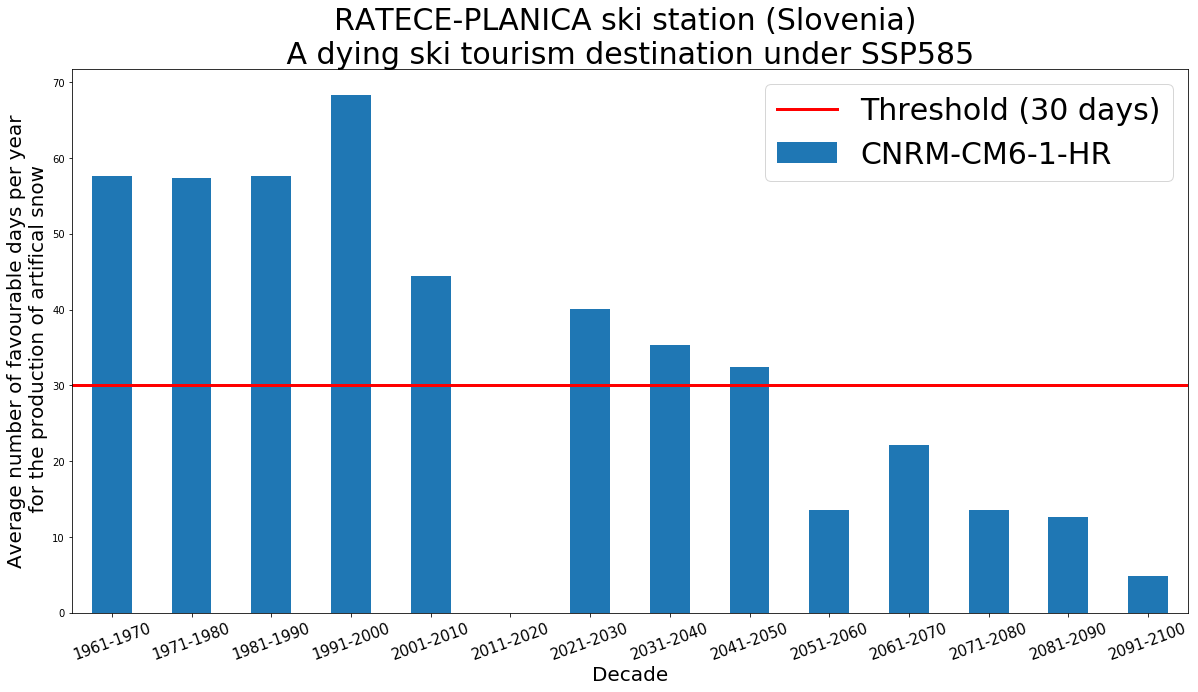

In [34]:
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
from dateutil.relativedelta import relativedelta

fig = plt.figure(1, figsize=[20,10])
ax = plt.subplot(1, 1, 1)
series10YS.plot.bar(ax=ax)
plt.axhline(y=30, color='r', linestyle='-', linewidth=3)
labels = [datetime.strptime(item.get_text(), '%Y-%m-%d %H:%M:%S').strftime("%Y") + '-' + 
            (datetime.strptime(item.get_text() , '%Y-%m-%d %H:%M:%S') +  relativedelta(years=9)).strftime("%Y")  for item in ax.get_xticklabels()] 
ax.set_xticklabels(labels, rotation=20, fontsize = 15)
ax.set_xlabel('Decade', fontsize = 20)
ax.set_ylabel('Average number of favourable days per year\n for the production of artifical snow', fontsize = 20)
plt.title("RATECE-PLANICA ski station (Slovenia) \n A dying ski tourism destination under SSP585 ", fontsize=30)
ax.legend(labels=['Threshold (30 days)','CNRM-CM6-1-HR'], fontsize=30)
plt.savefig("nb_favourable_snow_cmip6.png")

In [ ]:
client.shutdown()